# Load dataset

In [1]:
import pandas as pd
from data_preprocessing import *

2023-03-15 12:50:31.079431: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_dir = 'data/experiment3/'

X_df = pd.read_csv(f'{data_dir}HA-ANARCI_X.csv')
y_df = pd.read_csv(f'{data_dir}HA-ANARCI_y.csv')['binding']


In [3]:
def to_tf_dataset(x, y, y_label='binding',convert_dict=None):

    x = pd.DataFrame(x)
    if convert_dict:
        x = x.replace(convert_dict)
    y = pd.Series(y).reset_index(drop=True)
    full = pd.concat([x, y],axis=1)
    full.columns = [*list(map(str,list(range(1, x.shape[1]+1)))), y_label]
    # display(full.shape)

    return tfdf.keras.pd_dataframe_to_tf_dataset(full, label=y_label)


In [4]:

cdr_char = 'XEDRKHQNSTPGCAVILMFYW-'
test_size = 0.1

pad_len = []
for c in X_df[['VH_AA','VL_AA']]:
    pad_len.append(X_df[c].str.len().max())

codes_dict = {i: c for i, c in enumerate(cdr_char)}


In [69]:
X_df, y_df = subsample_stemhead(X_df, y_df)

[train_set, val_set, test_set], [X_train_id, X_eval_id, X_test_id], le = encode(X_df, y_df, cdr_char, test_size, pad_len)
[train_set_tf, val_set_tf, test_set_tf] = [to_tf_dataset(x, y, convert_dict=codes_dict) for (x,y) in [train_set, val_set, test_set]] ## debug


(240, 376)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(27, 376)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(30, 376)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


In [70]:
from tensorflow.keras.utils import to_categorical

(train_x, y_train), (val_x, y_val), (test_x, y_test) = [train_set, val_set, test_set]
y_train, y_val, y_test = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)
input_length = train_x.shape[1]

# Train

In [7]:
from tensorflow.keras import backend as K
from model_training import *


## deep learning models

### transformer model

In [56]:
def train_dl(CDR_model, train, val):

    METRICS = [
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        AUC(name='prc', curve='PR')
    ]

    (train_x, y_train), (val_x, y_val) = train, val
    
    CDR_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=BinaryCrossentropy(),
        metrics=METRICS,
    )

    callbacks = [EarlyStopping(patience=8, restore_best_weights=True)]

    CDR_history=CDR_model.fit(
        train_x, y_train,
        epochs=128, batch_size=128,
        validation_data=(val_x, y_val),
        callbacks=callbacks,
        verbose=0
    )
    
    return CDR_model, CDR_history


In [ ]:
K.clear_session()
CDR_model = CDR_model_single(max_length=input_length, n_classes=3)
CDR_model, CDR_history = train_dl(CDR_model, (train_x, y_train), (val_x, y_val))


In [58]:
eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_x, y_test, X_test_id), le)
display(eval_df)

(30, 3)


False    17
True     13
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
25,SpA3-02,others,head,0.333333,0.333333,0.333333
74,303-1F5,others,head,0.333333,0.333333,0.333333
80,R1142F-27Nov07-1HG8-4,others,head,0.333333,0.333333,0.333333
93,E4_52_CI-1_FU_P8S3_1,others,head,0.333333,0.333333,0.333333
90,317.4K.L009.01_W2,others,head,0.333333,0.333333,0.333333
63,N123-VRC34.04,others,head,0.333333,0.333333,0.333333
75,COV2-2676,others,head,0.333333,0.333333,0.333333
66,ISD102_P5G4,others,head,0.333333,0.333333,0.333333
52,70-5B01,others,head,0.333333,0.333333,0.333333
30,H02P3E7,others,head,0.333333,0.333333,0.333333


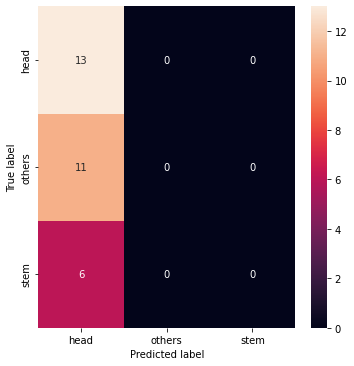

In [59]:
plot_cm_multi(label, pred_bool, le)

### feed forward network

In [60]:
# dense 

K.clear_session()
CDR_model = CDR_model_dense(max_length=input_length, n_classes=3)
CDR_model, CDR_history = train_dl(CDR_model, (train_x, y_train), (val_x, y_val))



In [61]:

eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_x, y_test, X_test_id), le)
display(eval_df)

(30, 3)


False    18
True     12
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
251,3652,head,others,0.246251,0.233622,0.520127
241,220-14-IgA_2C02,head,others,0.164560,0.408086,0.427354
237,1431-A,head,others,0.314825,0.202151,0.483025
234,2897,head,others,0.257850,0.178129,0.564021
201,H1N1_294-16-IgG-2D01_,head,stem,0.486296,0.300387,0.213318
282,113.0|Melbourne_donor_K77,head,others,0.133170,0.366372,0.500459
262,SFV018_2D01,head,stem,0.560424,0.145012,0.294564
21,321.5.PB.5.3C10,others,stem,0.729196,0.098453,0.172351
30,H02P3E7,others,stem,0.522365,0.219744,0.257890
66,ISD102_P5G4,others,head,0.141809,0.709874,0.148317


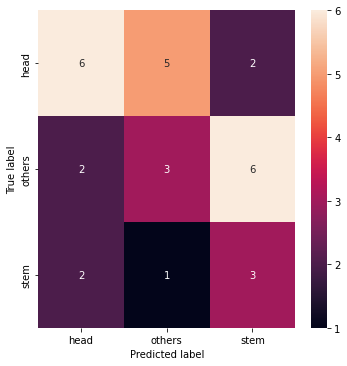

In [62]:
plot_cm_multi(label, pred_bool, le)

### random forest

In [65]:
import tensorflow as tf 

# save model

# model_save_dir = 'models/exp3_random_forest'
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

# CDR_model.save(model_save_dir)



# load model

model_load_dir = 'models/exp3_random_forest'
CDR_model_multi = tf.keras.models.load_model(model_load_dir, 
                                             custom_objects={
                                                 'recall_m': recall_m,
                                                 'precision_m': precision_m,
                                                 'f1_score': f1_score
                                             })
CDR_model = CDR_model_multi

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 14478 node(s), and 193 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestGeneric" built
[INFO kernel.cc:797] Use fast generic engine


In [44]:
# skip if loaded pre-trained model

def train_tree_multi(CDR_model, train, val):

    CDR_model.compile(
        metrics=[
            CategoricalAccuracy(name='accuracy'),
            precision_m, 
            recall_m,
            AUC(name='auc'),
            AUC(name='prc', curve='PR'),  # precision-recall curve
            ])

    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

    CDR_history=CDR_model.fit(
        x=train,
        validation_data=val,
        callbacks=callbacks,
        verbose=0
    )

    return CDR_model, CDR_history

K.clear_session()
CDR_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
CDR_model, CDR_history = train_tree_multi(CDR_model, train_set_tf, val_set_tf)


[INFO kernel.cc:727] Start Yggdrasil model training
[INFO kernel.cc:728] Collect training examples
[INFO kernel.cc:389] Number of batches: 4
[INFO kernel.cc:390] Number of examples: 240
[INFO data_spec_inference.cc:286] 6 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 1 (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 5 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 10 (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 9 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 101 (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 7 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 104 (5 item(s) left) because min_value_count=5 and max_number_of_unique_values=20

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 14358 node(s), and 180 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestGeneric" built
[INFO kernel.cc:797] Use fast generic engine


In [72]:
eval_df, pred, (label, pred_bool) = test_model_multi(CDR_model, (test_set_tf, y_test, X_test_id), le)
display(eval_df)


(30, 3)


True     29
False     1
dtype: int64

,Id,Label,Prediction,Probability Stem,Probability Head,Probability Others
291,26.0|Harrison_donor_TIV01,head,others,0.133333,0.43,0.436666


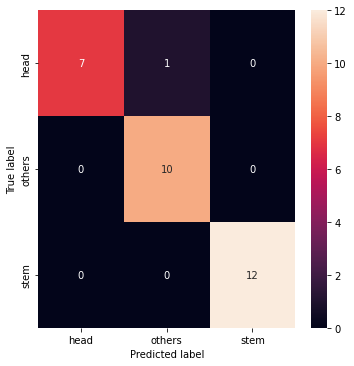

In [73]:
plot_cm_multi(label, pred_bool, le)

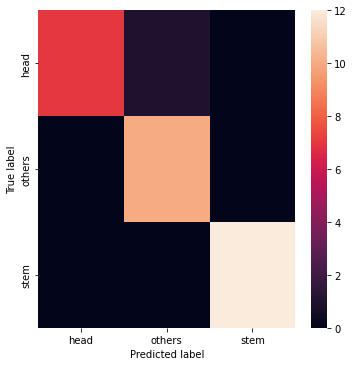

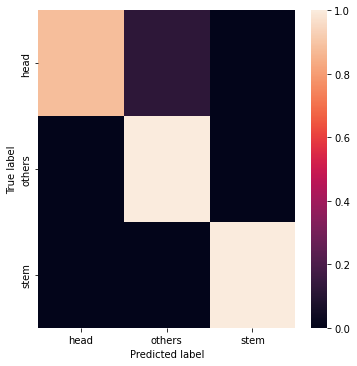

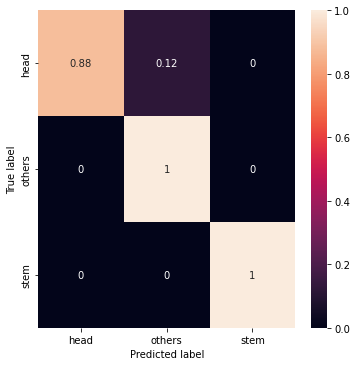

In [74]:
plot_cm_multi(label, pred_bool, le, annot=False)
plot_cm_multi(label, pred_bool, le, relative=True, annot=False)
plot_cm_multi(label, pred_bool, le, relative=True)

# Visualize

## extract decision tree rules

In [51]:
from viz_tree import *

In [52]:
# following tfdf library's default

num_trees = 300
max_depth = 16

rule_df = extract_tree(CDR_model, num_trees, max_depth)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:12<00:00,  4.13it/s]


## plot

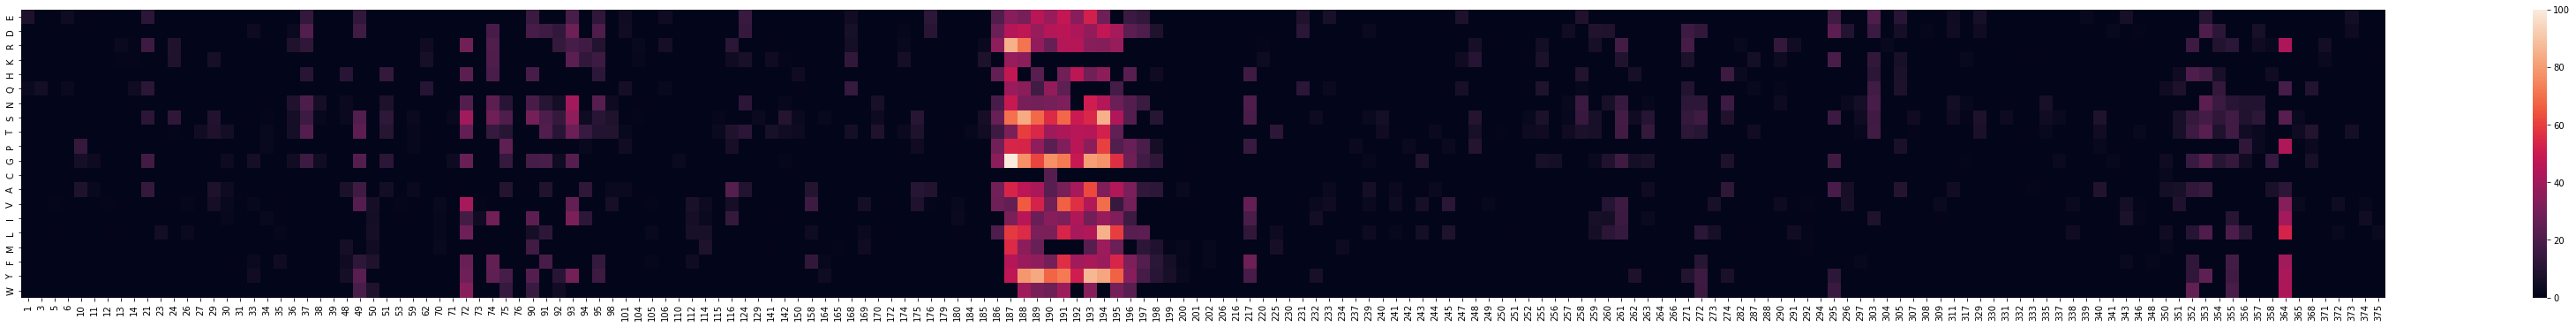

In [53]:
draw_heatmap(rule_df)

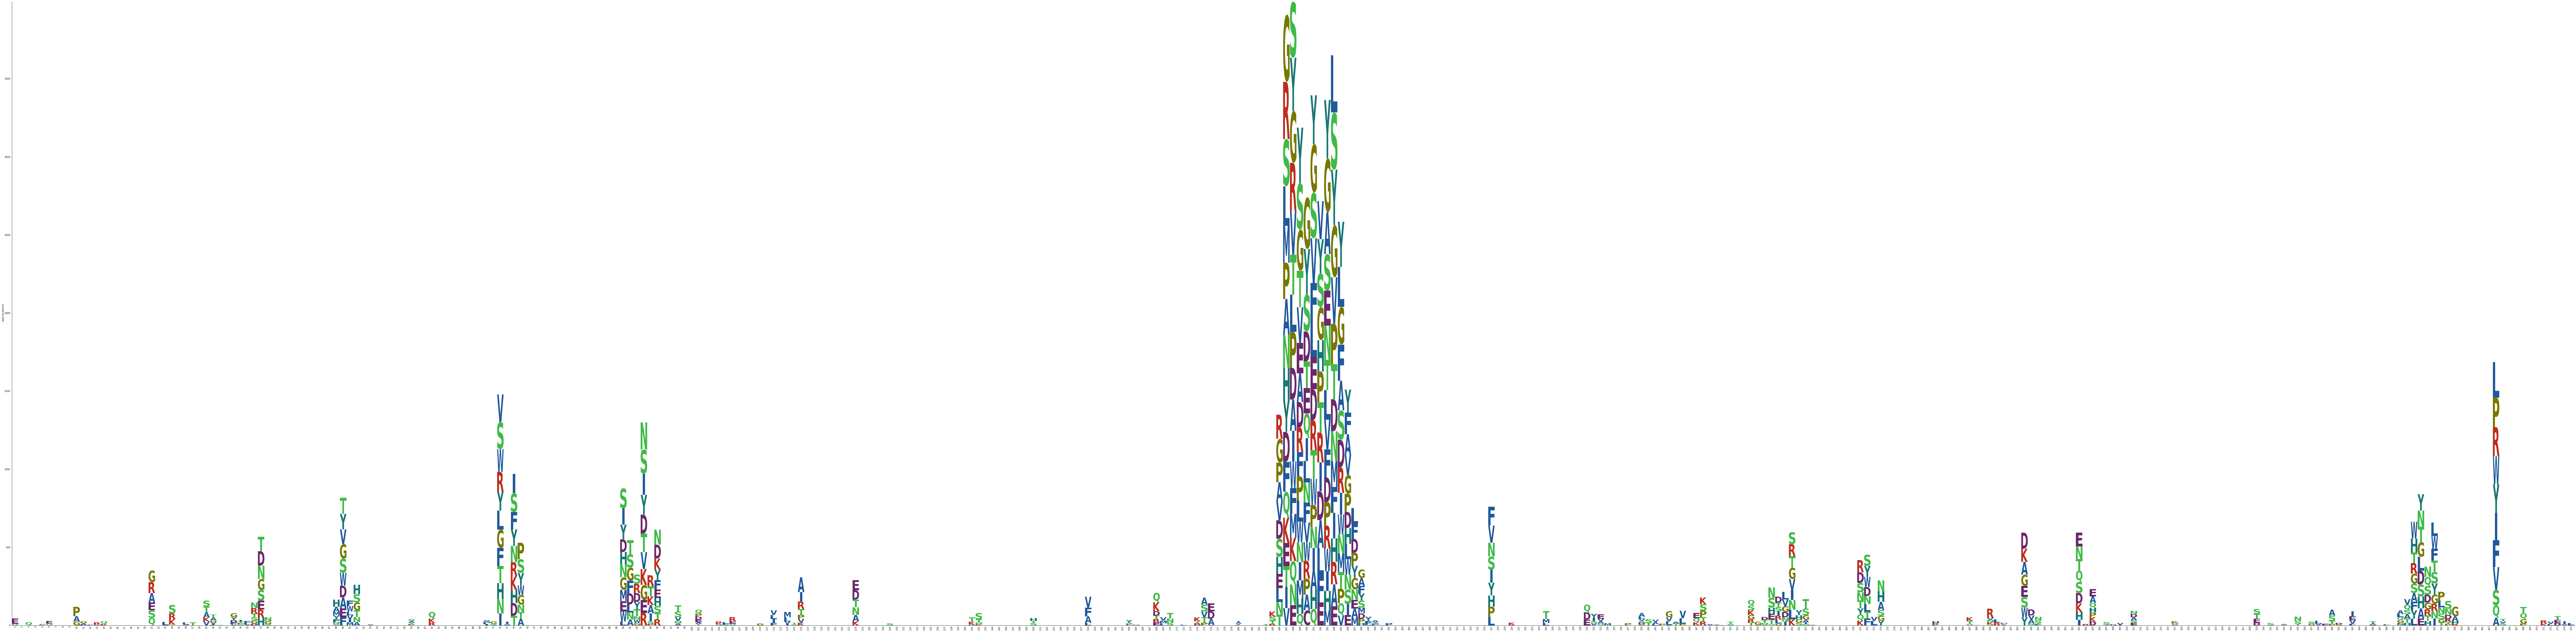

In [54]:
logosequence(rule_df)